In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import plotly.graph_objects as go

from cpn import load_model, image_preprocessing
from person_detection import crop_human
from pose_3d import Pose3DCPN

Using TensorFlow backend.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [14]:
# Camera parameters
R1 = np.array([[-0.1434, 0.9896, 0.0092],
              [0.1672, 0.0334, -0.9854],
              [-0.9754, -0.1397, -0.1702]])
R1_inv = np.linalg.inv(R1)
T1 = np.array([[-88.1, 804.8, 4315.3]]).T

R2 = np.array([[0.9654, 0.2600, -0.0214],
              [0.0151, -0.1372, -0.9904],
              [-0.2605, 0.9558, -0.1364]])
R2_inv = np.linalg.inv(R2)
T2 = np.array([[206.1, 955.7, 4062.3]]).T

# load 3d pose model
pose_3d_model = Pose3DCPN(R1, T1, R2, T2)

In [15]:
# start cv2 video capture

ds_dir = "dataset/humaneva_S1/"

cap_1 = cv2.VideoCapture(ds_dir + '3_1.avi')
cap_2 = cv2.VideoCapture(ds_dir + '3_2.avi')

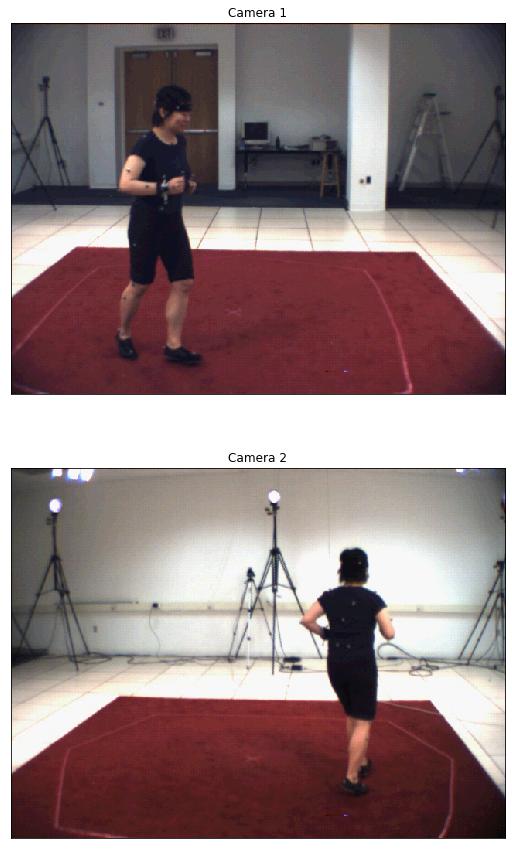

In [16]:
# get image frame

ret, cam_1 = cap_1.read()
ret, cam_2 = cap_2.read()

plt.figure(figsize=(15, 15))
plt.subplot(211, title="Camera 1")
plt.imshow(cam_1[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.subplot(212, title="Camera 2")
plt.imshow(cam_2[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.show()

In [17]:
# crop humans

crop_img_1, bbox_1 = crop_human(cam_1[:,:,[2,1,0]])
crop_img_2, bbox_2 = crop_human(cam_2[:,:,[2,1,0]])

crop_img_1 = cv2.cvtColor(crop_img_1, cv2.COLOR_BGR2RGB)
crop_img_2 = cv2.cvtColor(crop_img_2, cv2.COLOR_BGR2RGB)

img_1 = cv2.resize(crop_img_1, (288, 384))
img_2 = cv2.resize(crop_img_2, (288, 384))

pimg_1 = image_preprocessing(img_1)
pimg_2 = image_preprocessing(img_2)

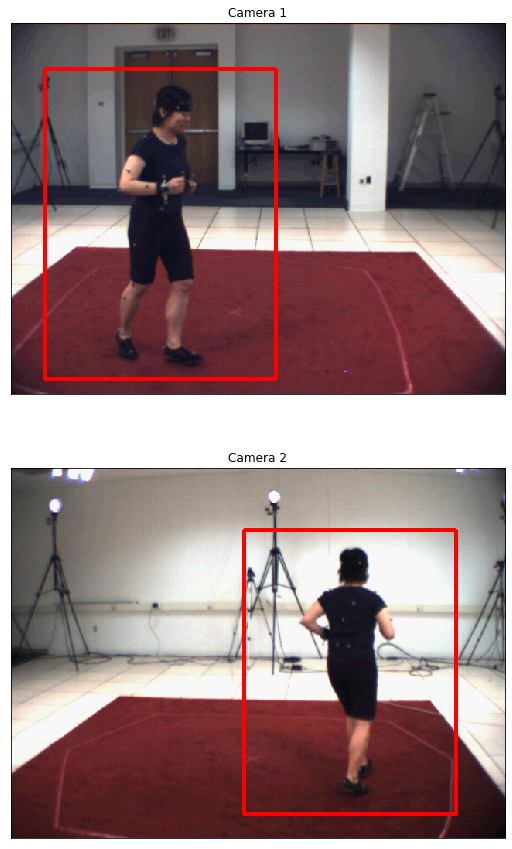

In [18]:
# draw bounding boxes

cam_1_bbox = cv2.rectangle(np.copy(cam_1), (bbox_1[1], bbox_1[0]), (bbox_1[3], bbox_1[2]), (0,0,255), 3)
cam_2_bbox = cv2.rectangle(np.copy(cam_2), (bbox_2[1], bbox_2[0]), (bbox_2[3], bbox_2[2]), (0,0,255), 3)

plt.figure(figsize=(15, 15))
plt.subplot(211, title="Camera 1")
plt.imshow(cam_1_bbox[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.subplot(212, title="Camera 2")
plt.imshow(cam_2_bbox[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.show()

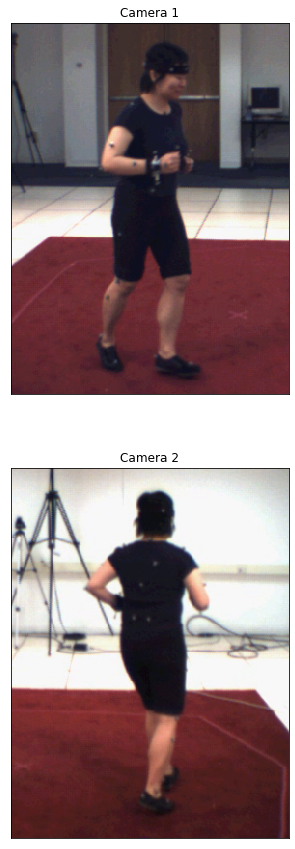

In [19]:
# show cropped images

plt.figure(figsize=(15, 15))
plt.subplot(211, title="Camera 1")
plt.imshow(img_1[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.subplot(212, title="Camera 2")
plt.imshow(img_2[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.show()

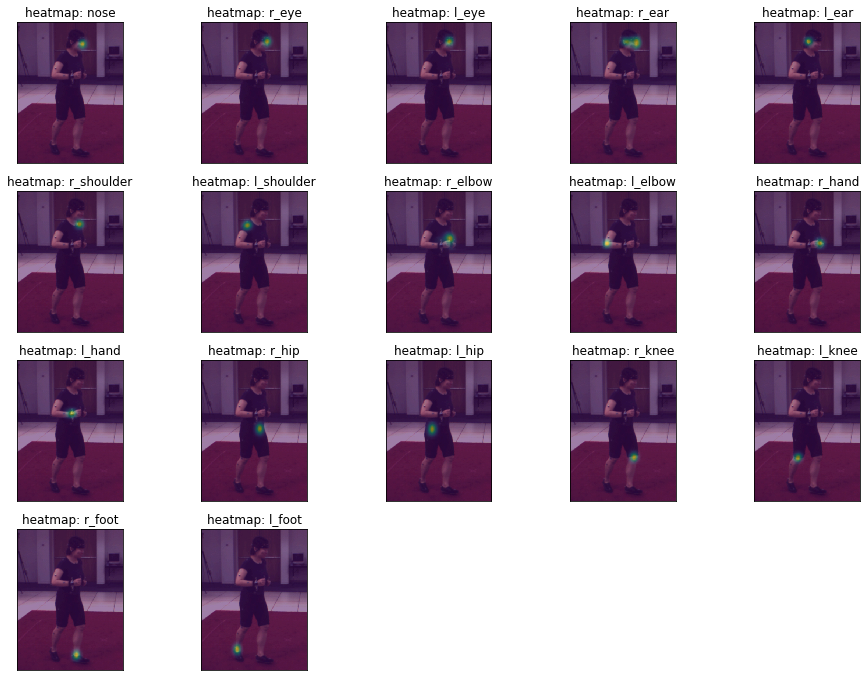

In [21]:
heatmap_1 = pose_3d_model.gen_heatmaps(img_1, pimg_1, plot_fig=True)

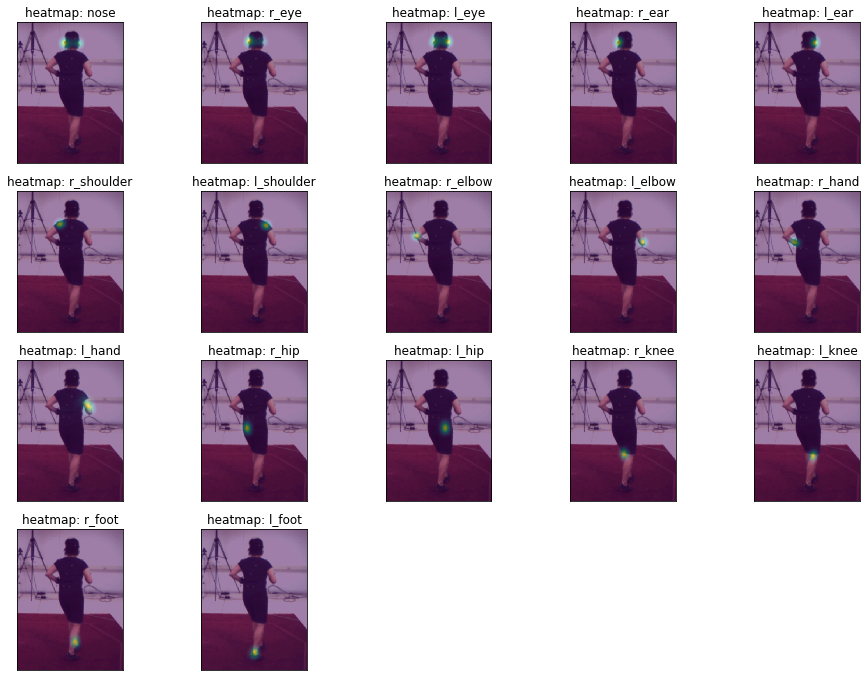

In [22]:
heatmap_2 = pose_3d_model.gen_heatmaps(img_2, pimg_2, plot_fig=True)

In [23]:
# extract 2d keypoints

kpt_1 = pose_3d_model.extract_kpt_2d(heatmap_1, bbox_1, crop_img_1)
skl_img_1 = pose_3d_model.draw_skl(cam_1[:,:,[2,1,0]], kpt_1)

kpt_2 = pose_3d_model.extract_kpt_2d(heatmap_2, bbox_2, crop_img_2)
skl_img_2 = pose_3d_model.draw_skl(cam_2[:,:,[2,1,0]], kpt_2)

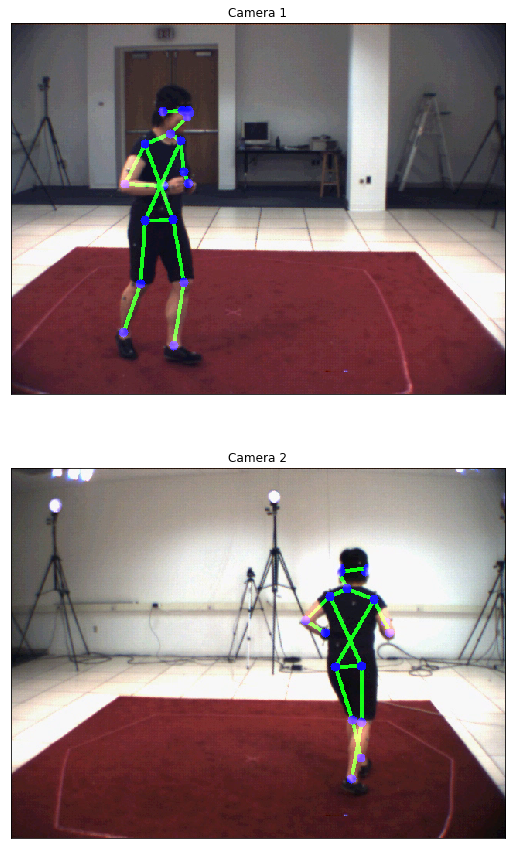

In [24]:
# plot 2d skeletons

plt.figure(figsize=(15, 15))
plt.subplot(211, title="Camera 1")
plt.imshow(skl_img_1)
plt.xticks([])
plt.yticks([])
plt.subplot(212, title="Camera 2")
plt.imshow(skl_img_2)
plt.xticks([])
plt.yticks([])
plt.show()

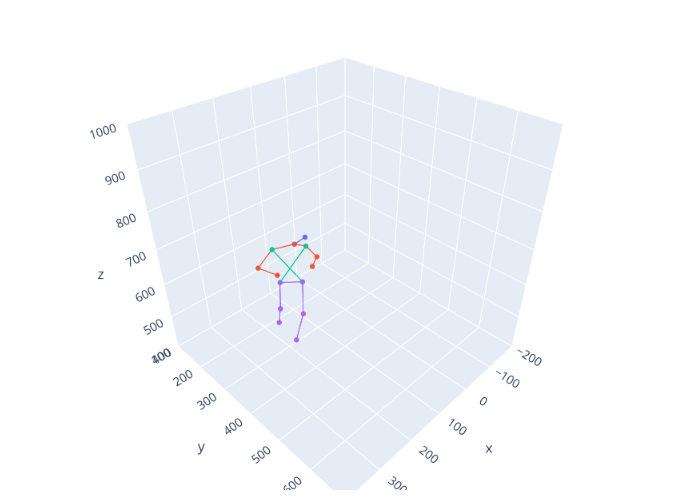

In [28]:
# calculate 3d pose and show fig

kpt_3D = pose_3d_model.calc_3D_kpt(kpt_1, kpt_2)

fig = go.Figure()
fig = pose_3d_model.get_3D_fig(fig, kpt_3D)

camera = dict(eye=dict(x=-2, y=2, z=0.1))
fig.update_layout(
    showlegend = False,
    scene = dict(xaxis = dict(range=[-200,400],),
                 yaxis = dict(range=[100,700],),
                 zaxis = dict(range=[400,1000],),),
    margin=dict(r=20, l=10, b=10, t=10),
    scene_aspectmode='cube',
)

img_bytes = fig.to_image(format="png")

from IPython.display import Image
Image(img_bytes)